### advent callendar


# Get metadata

# 0. ライブラリのインポートと設定

In [ ]:
from time import sleep
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

# このパスの下にダウンロードしたデータやらいろいろ置きます。
DATA_PATH = Path("../data")
(DATA_PATH / "xbrl_doc").mkdir(parents=True, exist_ok=True) # ダウンロードしたzipファイルの保管場所
(DATA_PATH / "raw/xbrl_doc_ext").mkdir(parents=True, exist_ok=True) # zipファイルから抽出したXBRL、スキーマファイル、リンクベースファイルの保管場所

# EDINET APIのAPIキーを入力してください。
your_api_key: str = input("Please input your EDINET API key: ")


# 1. 提出書類一覧の取得

In [2]:
from edinet_xbrl_prep.edinet_api import request_term, edinet_response_metadata, request_doc

In [ ]:
res_results = request_term(api_key=your_api_key, start_date_str='2024-06-15', end_date_str='2024-06-30')

In [ ]:
edinet_response_metadata_obj = edinet_response_metadata(
    tse_sector_url = "https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls",
    tmp_path = DATA_PATH
)
edinet_response_metadata_obj.set_data(res_results)
filename = str(DATA_PATH / "data.jsonl")
edinet_response_metadata_obj.save(filename)

In [ ]:
edinet_response_metadata_obj = edinet_response_metadata(
    filename = DATA_PATH / "data.jsonl",
    tse_sector_url = "https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls",
    tmp_path = DATA_PATH
    )

yuho_df = edinet_response_metadata_obj.get_yuho_df()

In [233]:
yuho_df_filtered = yuho_df.query("sector_label_33 == '食料品'")
print("業種が食料品の有価証券報告書数:",len(yuho_df_filtered))

業種が食料品の有価証券報告書数: 79


# 2. 有価証券報告書のダウンロード

In [234]:
download_docid_list = yuho_df_filtered.docID.to_list()

In [ ]:
res_results = []
for docid in tqdm(download_docid_list):
    out_filename = DATA_PATH / "xbrl_doc" / (docid + ".zip")
    res_results.append(request_doc(api_key=your_api_key, docid=docid, out_filename_str=out_filename))
    sleep(0.5)


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


# 3. Preprocessing

In [9]:
from edinet_xbrl_prep.link_base_file_analyzer import account_list_common
from edinet_xbrl_prep.fs_tbl import get_fs_tbl


In [ ]:
# 3.1 共通タクソノミの取得（100秒程度）
account_list_common_obj_2024 = account_list_common(
    data_path=DATA_PATH,
    account_list_year="2024"
)

In [ ]:
# arelleの設定（特段不要ですが、）
arelle_temp_dir = Path(DATA_PATH/"tmp")
arelle_dir = arelle_temp_dir.joinpath('arelle_tmp')
arelle_dir.mkdir(exist_ok=True)
cmd_arelle_dir = '--xdgConfigHome=' + str(arelle_dir)
sys.argv.append(cmd_arelle_dir)
# XBRLの展開先
(DATA_PATH / "raw/xbrl_doc_ext").mkdir(parents=True, exist_ok=True)


#### 財務数値の取り出し
有価証券報告書XBRLから財務数値を取得します。

In [ ]:
# リンクロール検索キーワード
fs_dict = {
    'BS':["_BalanceSheet","_ConsolidatedBalanceSheet"],
    'PL':["_StatementOfIncome","_ConsolidatedStatementOfIncome"],
    'CF':["_StatementOfCashFlows","_ConsolidatedStatementOfCashFlows"],
    'SS':["_StatementOfChangesInEquity","_ConsolidatedStatementOfChangesInEquity"],
    'notes':["_Notes","_ConsolidatedNotes"],
    'report':["_CabinetOfficeOrdinanceOnDisclosure"]}

In [ ]:
# XBRLから必要なロールの財務情報を取得
fs_tbl_df_list = []
for docid in tqdm(download_docid_list[1:30]):
    fs_tbl_df = get_fs_tbl(
        account_list_common_obj=account_list_common_obj_2024,
        docid=docid,
        zip_file_str=DATA_PATH / "raw/xbrl_doc" / (docid + ".zip"),
        temp_path_str=DATA_PATH / "raw/xbrl_doc_ext" / docid,
        role_keyward_list=fs_dict['BS']+fs_dict['PL']+fs_dict['CF']+fs_dict['SS']+fs_dict['report'],
    )
    fs_tbl_df_list.append(fs_tbl_df)
fs_tbl_df_all=pd.concat(fs_tbl_df_list)


 69%|██████▉   | 20/29 [11:41<05:46, 38.47s/it]

key in label that is not included in locator: 
{'StrategySupplyChainTextBlock'}


100%|██████████| 29/29 [16:31<00:00, 34.20s/it]


# 4. テキスト分析

In [ ]:
# 有価証券報告書の前段部分を取得
text_df = fs_tbl_df_all.query("role.str.contains('CabinetOfficeOrdinanceOnDisclosure')")

## 4.1 事業上のリスクの分析

In [ ]:
from janome.tokenizer import Tokenizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel,TfidfModel

import wordcloud as wc
import matplotlib.pyplot as plt
import matplotlib_fontja

from matplotlib_fontja import get_font_path
from matplotlib import font_manager

from edinet_xbrl_prep.text_prep import *

# wordcloud用に日本語のフォントを取得
font_dir_path = get_font_path()
font_dirs = [font_dir_path]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

In [ ]:
business_risk_df = text_df.query("key == 'jpcrp_cor:BusinessRisksTextBlock'")

In [ ]:

janome_tokenizer = Tokenizer()
def tokenize_janome(text:str)->str:
    return [token.surface for token in janome_tokenizer.tokenize(text) if token.part_of_speech.split(',')[0] in ['名詞','形容詞']]

business_risk_df['text_processed'] = business_risk_df.data_str.apply(preproc_nlp,drop_htmp=True,drop_number=True,reduce_return=True)
business_risk_df['text_tokenized'] = business_risk_df.text_processed.apply(tokenize_janome)

business_risk_df.head()['text_tokenized']

In [ ]:
dictionary = Dictionary(business_risk_df['text_tokenized'].to_list())
# 1書類にしか出現しない単語、70%以上の書類に出現する単語を削除
dictionary.filter_extremes(no_below=2, no_above=0.7,keep_n=400000)
# トークンIDに変換
business_risk_df = business_risk_df.assign(text_tokenized_id=business_risk_df.text_tokenized.apply(dictionary.doc2bow))

tf_idf = True
bow_corpus = business_risk_df.text_tokenized_id.to_list()
# TF-IDFを計算
if tf_idf:
    tfidf = TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    corpus = corpus_tfidf
else:
    corpus = bow_corpus

NUM_TOPICS = 10 # トピック数
# LDAモデルの学習
lda=LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary,alpha='auto')


[(0,
  '0.004*"多大" + 0.003*"株式会社" + 0.003*"機会" + 0.002*"チャネル" + 0.002*"冷凍" + 0.002*"人権" + 0.002*"同社" + 0.002*"調理" + 0.002*"魚" + 0.002*"年"'),
 (1,
  '0.004*"糖" + 0.003*"概要" + 0.002*"砂糖" + 0.002*"悪影響" + 0.002*"台湾" + 0.002*"菓子" + 0.002*"人材" + 0.002*"農業" + 0.002*"ポテトチップス" + 0.002*"作況"'),
 (2,
  '0.004*"糖" + 0.002*"調整" + 0.002*"保険" + 0.002*"協定" + 0.002*"ビジョン" + 0.002*"これ" + 0.002*"加入" + 0.002*"穀物" + 0.002*"砂糖" + 0.002*"重大"'),
 (3,
  '0.005*"時期" + 0.003*"なし" + 0.002*"病原" + 0.002*"店舗" + 0.002*"米国" + 0.002*"製" + 0.002*"顕在" + 0.002*"進捗" + 0.002*"数値" + 0.002*"外部"'),
 (4,
  '0.002*"悪影響" + 0.001*"仮定" + 0.001*"予想" + 0.001*"他" + 0.001*"作業" + 0.001*"財務" + 0.001*"財産" + 0.001*"知的" + 0.001*"税金" + 0.001*"役職"'),
 (5,
  '0.002*"退職" + 0.002*"給付" + 0.002*"水産" + 0.002*"熊本" + 0.002*"仮定" + 0.002*"重大" + 0.002*"新設" + 0.002*"センター" + 0.002*"畜産" + 0.002*"ソフト"'),
 (6,
  '0.003*"中国" + 0.003*"汚染" + 0.002*"悪影響" + 0.002*"公的" + 0.002*"決議" + 0.002*"年月日" + 0.002*"仕入れ" + 0.002*"株式" + 0.002*"員" + 0.002*"取締役"'),
 (7,
  '0.004*

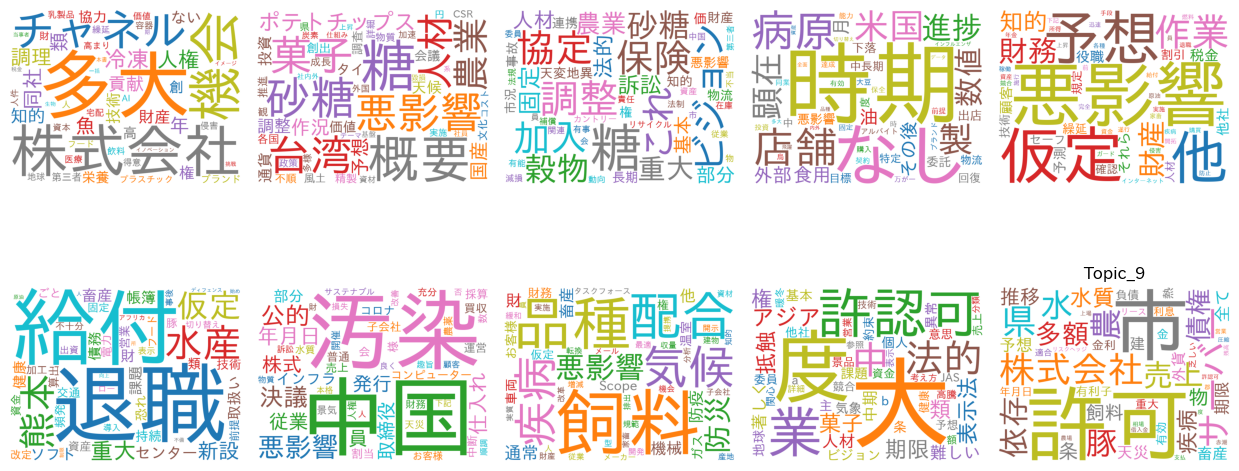

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(12.5,6.5))
for itr_topic_num in range(NUM_TOPICS):
    row = itr_topic_num // 5
    col = itr_topic_num % 5
    wordcloud = wc.WordCloud(
        background_color="white",
        font_path=font_files[0],
        width=800,
        height=600,
        max_words=200,
        min_font_size=1,
        colormap='tab10',
    ).generate_from_frequencies(dict([(word,np.exp(score)-1) for word,score in lda.show_topic(itr_topic_num, topn=50)]))
    ax[row,col].imshow(wordcloud)
    ax[row,col].axis("off")
    plt.title("Topic_" + str(itr_topic_num))
fig.tight_layout()
plt.show()

## 4.2 事業の抽出

In [237]:
from edinet_xbrl_prep.text_prep import *

In [ ]:
# 有価証券前段から事業の内容を取得し、前処理
business_desc_df = text_df.query("key == 'jpcrp_cor:DescriptionOfBusinessTextBlock'")
business_desc_df['text_processed'] = business_desc_df.data_str.apply(preproc_nlp,drop_htmp=True,drop_number=False,reduce_return=True)

In [ ]:
# プロンプトの設定
example_text="""
##### 文章
3 【事業の内容】当社の主たる事業は物流業であります
その事業は貨物運送事業、倉庫事業、その他事業に区分されますが、それぞれの事業内容は次のとおりであります
イ 貨物運送事業貨物自動車運送事業法に基づく、一般貨物自動車運送事業の許可をうけて、愛知県、岐阜県、三重県、及び静岡県を営業区域とし、主に食料品、日用品雑貨等、消費関連貨物の輸送を行っております
また、貨物運送取扱事業法に基づく第一、第二種利用運送事業の許可もうけております
現在、愛知県下に8支店、三重県下に1支店の拠点を持ち、倉庫業とともに総合的な物流サービスの一環として効率的な輸送サービスの提供を行っております
ロ 倉庫事業倉庫業法に基づく倉庫業の許可をうけて、愛知県下に2か所の営業倉庫と6か所の物流センター、三重県下に1か所の物流センターを持ち、貨物運送事業との連携により集荷・保管・流通加工・配送・回収までの一貫した総合物流サービスに努めております
ハ その他事業道路運送車両法に基づく自動車分解整備事業の認証をうけて、愛知県下に1か所の整備工場民間車検工場指定を持ち、自動車の車検、定期点検、一般修理を行っておりますほか、付帯して損害保険代理店事業を営んでおります
また、三好支店において太陽光発電事業を行っております
 また、子会社大宝興業株式会社はビルの賃貸を主たる業務としております

##### 回答
```json
{"事業内容":"貨物運送事業","具体的な説明":"食料品、日用品雑貨等の消費関連貨物の輸送に加え、第一・第二種利用運送事業も実施。"}
{"事業内容":"倉庫事業","具体的な説明":"営業倉庫と物流センターの運営。集荷・保管・流通加工・配送・回収までの一貫したサービスを提供"}
{"事業内容":"自動車整備事業","具体的な説明":"車検、定期点検、一般修理"}
{"事業内容":"損害保険代理店事業","具体的な説明":"なし"}
{"事業内容":"太陽光発電事業","具体的な説明":"なし"}
{"事業内容":"不動産賃貸事業","具体的な説明":"なし"}
```
以上の指示に従って、提供された文章から、事業内容を抽出して整理してください。
"""

prompt_ext_business = Prompt(**{
    "instruction": """提供される文章はある会社の事業内容に関する文章の抜粋です。ここからわかる会社の主な事業内容を日本語で列挙してください。""",
    "example": example_text,
    "constraints_list": ["できるだけ文章中の記載をそのまま引用してください。","固有名詞は伏せてください。","具体的な説明がある場合は、それも記載してください。ない場合は「なし」としてください。"],
    "output_format": """#### 回答形式\n\nフォーマットは個別のjson形式で回答してください。\n\n{"事業内容":"(事業内容1)","具体的な説明":"(具体的な説明1)"}\n{"事業内容":"(事業内容2)","具体的な説明":"(具体的な説明2)"}""",
    })

sample_text="""3 【事業の内容】当社の主たる事業は物流業であります\nその事業は貨物運送事業、倉庫事業、その他事業に区分されますが、それぞれの事業内容は次のとおりであります\nイ 貨物運送事業貨物自動車運送事業法に基づく、一般貨物自動車運送事業の許可をうけて、愛知県、岐阜県、三重県、及び静岡県を営業区域とし、主に食料品、日用品雑貨等、消費関連貨物の輸送を行っております\nまた、貨物運送取扱事業法に基づく第一、第二種利用運送事業の許可もうけております\n現在、愛知県下に8支店、三重県下に1支店の拠点を持ち、倉庫業とともに総合的な物流サービスの一環として効率的な輸送サービスの提供を行っております\nロ 倉庫事業倉庫業法に基づく倉庫業の許可をうけて、愛知県下に2か所の営業倉庫と6か所の物流センター、三重県下に1か所の物流センターを持ち、貨物運送事業との連携により集荷・保管・流通加工・配送・回収までの一貫した総合物流サービスに努めております\nハ その他事業道路運送車両法に基づく自動車分解整備事業の認証をうけて、愛知県下に1か所の整備工場民間車検工場指定を持ち、自動車の車検、定期点検、一般修理を行っておりますほか、付帯して損害保険代理店事業を営んでおります\nまた、三好支店において太陽光発電事業を行っております\n また、子会社大宝興業株式会社はビルの賃貸を主たる業務としております"""

# 例を出力
prompt_ext_business.export_sample(sample_text)

In [ ]:
your_api_key_groq: str = input("Please input your Groq API key: ")
GroqAPI_obj = GroqAPI(api_key=your_api_key_groq)

In [ ]:

def extract_business_description(sr:pd.Series)->list:
    sys_prompt,usr_prompt = prompt_ext_business.export(provided_text=sr.text_processed)
    response = GroqAPI_obj.request(sys_prompt=sys_prompt,usr_prompt=usr_prompt)
    if not response.output_json_validation():
        sleep(1)
        response2 = GroqAPI_obj.request(sys_prompt=sys_prompt,usr_prompt=usr_prompt)
        if not response2.output_json_validation():
            print("Error")
            return []
        else:
            response = response2
    output_json_list = response.extract_output_json()
    return output_json_list

# 120秒程度
business_desc_df['business_extracted'] = business_desc_df.apply(extract_business_description,axis=1)


## 5. 財務数値の分析

### 5.1 在庫の分析

In [ ]:
# 設定
import matplotlib.pyplot as plt
import matplotlib_fontja
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from edinet_xbrl_prep.num_prep import preproc_num, fill_df

np.random.seed(seed=1)

In [ ]:
# BSの抽出
bs_df = fs_tbl_df_all.query("non_consolidated_flg==0 and current_flg==1 and role.str.contains('BalanceSheet')")

In [ ]:
# 在庫の抽出
inventory_df = bs_df.query("label_jp.str.contains('商品及び製品') or label_jp.str.contains('仕掛品') or label_jp.str.contains('原材料及び貯蔵品')")

In [ ]:
# 数値データの前処理
inventory_df = preproc_num(inventory_df) # テキストを数値に変換など
inventory_df_filled = fill_df(inventory_df) # 欠損値の補完
inventory_df_pivot = pd.crosstab(index=inventory_df_filled['docid'], columns=inventory_df_filled['label_jp'], values=inventory_df_filled['data'], aggfunc='sum',normalize='index')

In [ ]:
# 似ている企業が近くなるように並べ替え
def aitchison_scaling(x):
    return np.log(x/np.exp(np.mean(np.log(x))))

def pca_sort(data:pd.DataFrame)->pd.DataFrame:
    """第一主成分でソート"""
    pca = PCA(n_components=1)

    data_scaled = data#.apply(aitchison_scaling, axis=1)
    data['pc1_scores'] = pca.fit_transform(data_scaled)

    sorted_df = data.sort_values('pc1_scores')
    sorted_df = sorted_df.drop('pc1_scores', axis=1)
    return sorted_df

reordered_inventory_df_pivot = pca_sort(inventory_df_pivot)


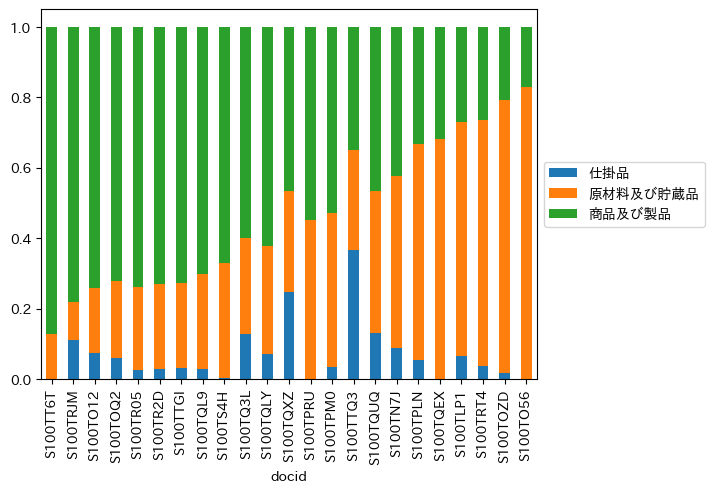

In [ ]:
# 積み上げ棒グラフの描画
reordered_inventory_df_pivot.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### 5.2 在庫の分析と事業

In [ ]:
# 4.2で取得した事業内容を結合
reordered_inventory_df_pivot2 = pd.merge(
    reordered_inventory_df_pivot,
    business_desc_df.set_index('docid')[['business_extracted']],
    left_index=True,
    right_index=True,
    how='left'
)

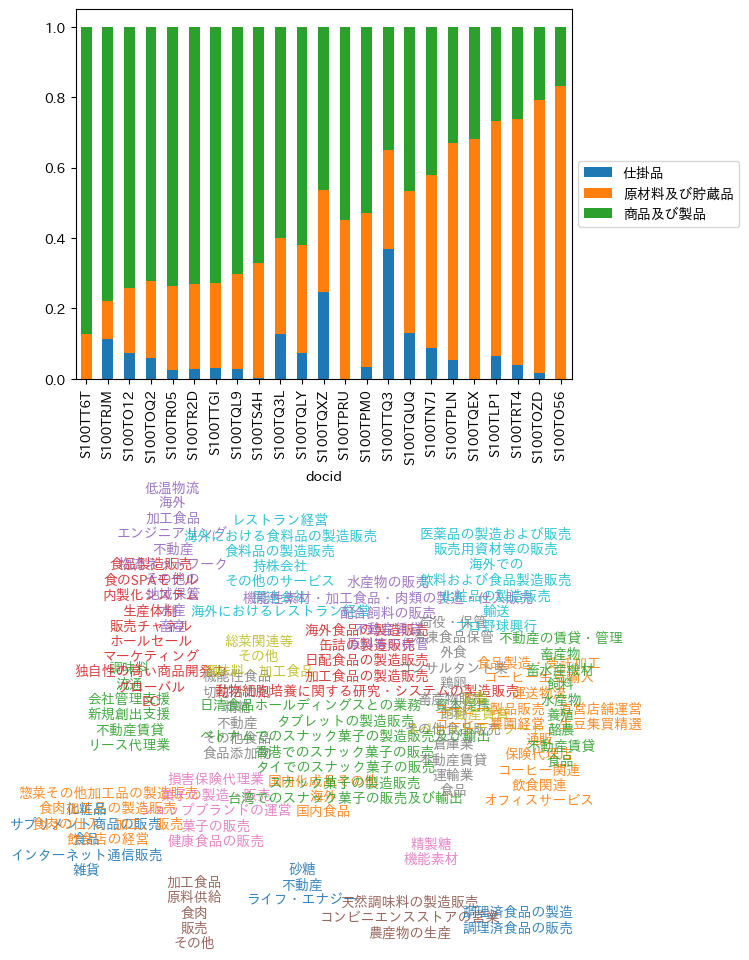

In [ ]:
# 事業内容と一緒に描画
cmap = get_cmap('tab10')

dic_box = {
    'facecolor' : 'lightblue',
    'edgecolor' : 'black',
    'boxstyle' : 'Round, pad=0.8',
    'linewidth' : 1
}
reordered_inventory_df_pivot2.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
for itr,index in enumerate(reordered_inventory_df_pivot2.index):
    text_list = reordered_inventory_df_pivot2.loc[index,'business_extracted']
    if text_list is not np.nan:
        text = "\n".join(list(set([text['事業内容'] for text in text_list]))).replace('事業','')
        plt.text(x=itr, y=-1.7 + 0.2*(itr % 5) + 0.3*np.random.rand(), s=text, 
            color=cmap(itr % 10),
            ha='center', fontsize='10', alpha=0.9,
            #bbox=dic_box
            )

### 5.3 営業利益率の分析

In [ ]:
# PLの取得
pl_df=fs_tbl_df_all.query("non_consolidated_flg==0 and current_flg==1 and role.str.contains('StatementOfIncome')")

In [ ]:
# PLから営業利益の取得
profit_df = pl_df.query("label_jp.str.contains('営業利益又は営業損失（△）')")
profit_df = preproc(profit_df)
profit_df = profit_df.sort_values('context_ref_len',ascending=True).drop_duplicates(keep='first',subset=['docid','key'])
len(profit_df)

24

In [ ]:
# PLから売上の取得
sales_df = pl_df.query("label_jp.str.contains('売上高')")
sales_df = preproc(sales_df)
sales_df = sales_df.sort_values('context_ref_len',ascending=True).drop_duplicates(keep='first',subset=['docid','key'])
len(sales_df)

24

In [ ]:
# PLから総資産の取得
scaler_df = bs_df.query("key == 'jppfs_cor:Assets'")
scaler_df = preproc(scaler_df)
scaler_df = scaler_df.sort_values('context_ref_len',ascending=True).drop_duplicates(keep='first',subset=['docid','key'])
len(scaler_df)

24

Text(0, 0.5, 'Profit rate (million yen)')

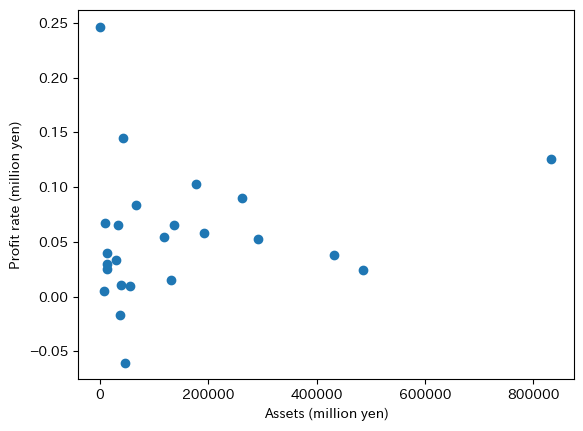

In [ ]:
# 散布図の描画
plt.scatter(scaler_df.set_index('docid').data/1000000, profit_df.set_index('docid').data/sales_df.set_index('docid').data)
plt.xlabel('Assets (million yen)')
plt.ylabel('Profit rate (million yen)')

## 6. SQLITE3への出力

In [240]:
import	sqlite3

file_sqlite3 = DATA_PATH / "xbrl_parsed.db"
conn = sqlite3.connect(str(file_sqlite3))
fs_tbl_df_all.to_sql('xbrl_parsed',conn,index=None,if_exists='replace')
conn.close()
